## 1. Import Modul dan hubungkan dengan drive

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf

In [ ]:
!pip install split-folders

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import splitfolders

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

## 2. Data Preperetion


# Data Load

In [ ]:
# prompt: saya mau meng unzip /content/drive/MyDrive/DICODING/DATA SET SAMPAH.zip

!unzip '/content/drive/MyDrive/DICODING/DATA SET SAMPAH.zip' -d "/content/drive/MyDrive/DICODING/Klasisfikasi sampah baru capstone"


Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: /content/drive/MyDrive/DICODING/Klasisfikasi sampah baru capstone/DATA SET SAMPAH/Anorganik/R_1900.jpg  
  inflating: /content/drive/MyDrive/DICODING/Klasisfikasi sampah baru capstone/__MACOSX/DATA SET SAMPAH/Anorganik/._R_1900.jpg  
  inflating: /content/drive/MyDrive/DICODING/Klasisfikasi sampah baru capstone/DATA SET SAMPAH/Anorganik/R_9390.jpg  
  inflating: /content/drive/MyDrive/DICODING/Klasisfikasi sampah baru capstone/__MACOSX/DATA SET SAMPAH/Anorganik/._R_9390.jpg  
  inflating: /content/drive/MyDrive/DICODING/Klasisfikasi sampah baru capstone/DATA SET SAMPAH/Anorganik/R_1914.jpg  
  inflating: /content/drive/MyDrive/DICODING/Klasisfikasi sampah baru capstone/__MACOSX/DATA SET SAMPAH/Anorganik/._R_1914.jpg  
  inflating: /content/drive/MyDrive/DICODING/Klasisfikasi sampah baru capstone/DATA SET SAMPAH/Anorganik/R_648.jpg  
  inflating: /content/drive/MyDrive/DICODING/Klasisfikasi sampah baru capstone/__MA

In [ ]:
import os

dataset_path = "/content/drive/MyDrive/DICODING/Klasisfikasi sampah baru capstone/DATA SET SAMPAH"  # Update this path

class_counts = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):  # Check if it's a directory (a class)
        class_counts[class_name] = len(os.listdir(class_dir))

for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Count: {count}")


Class: Organik, Count: 0
Class: Anorganik, Count: 0


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os


dataset_path = "/content/drive/MyDrive/DICODING/Klasisfikasi sampah baru capstone/DATA SET SAMPAH"  # Update this path

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        if image_files:
            first_image_path = os.path.join(class_dir, image_files[33])
            try:
                img = mpimg.imread(first_image_path)
                plt.imshow(img)
                plt.title(f"First image of class: {class_name}")
                plt.axis('off')
                plt.show()
            except Exception as e:
                print(f"Error displaying image {first_image_path}: {e}")
        else:
            print(f"No images found in directory: {class_dir}")


No images found in directory: /content/drive/MyDrive/DICODING/Klasisfikasi sampah baru capstone/DATA SET SAMPAH/Organik
No images found in directory: /content/drive/MyDrive/DICODING/Klasisfikasi sampah baru capstone/DATA SET SAMPAH/Anorganik


In [ ]:
print("Nama-nama kelas:")
for kelas in image_df['Label'].unique():
    print(kelas)

# Data Split


In [ ]:
input_folder = "/content/drive/MyDrive/DICODING/Klasisfikasi sampah baru capstone/DATA SET SAMPAH"

output_folder = "/content/drive/MyDrive/DICODING/split_dataset_sampah_capstone"

# Membagi dataset: 80% train, 10% val, 10% test
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .1, .1), move=True)

Copying files: 0 files [00:00, ? files/s]


# 3. Data Preprocesing

In [ ]:
base_dir = '/content/drive/MyDrive/DICODING/split_dataset_sampah_capstone'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')


IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64


In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 20060 images belonging to 2 classes.
Found 2507 images belonging to 2 classes.
Found 2510 images belonging to 2 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.93 and logs.get('val_accuracy') > 0.93):
      print('\n Accuracy sudah mencapai > 93%')
      self.model.stop_training = True

callbacks = myCallback()


# 4. Pembuatan Model CNN

In [ ]:
def create_model():
    model = Sequential([
        # Layer 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D(pool_size=(2, 2)),

        # Layer 2
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Layer 3
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Flatten dan Dense layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Membuat model
model = create_model()
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,218 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks untuk training
checkpoint = ModelCheckpoint(
    'bag_classifier_best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.7686 - loss: 0.6655 
Epoch 1: val_accuracy improved from -inf to 0.84415, saving model to bag_classifier_best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 5173s 17s/step - accuracy: 0.7687 - loss: 0.6649 - val_accuracy: 0.8442 - val_loss: 0.3685
Epoch 2/10
  1/313 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.7188 - loss: 0.5861

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.84415 to 0.84776, saving model to bag_classifier_best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7188 - loss: 0.5861 - val_accuracy: 0.8478 - val_loss: 0.3629
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8377 - loss: 0.3928
Epoch 3: val_accuracy did not improve from 0.84776
313/313 ━━━━━━━━━━━━━━━━━━━━ 441s 1s/step - accuracy: 0.8378 - loss: 0.3928 - val_accuracy: 0.8405 - val_loss: 0.4451
Epoch 4/10
  1/313 ━━━━━━━━━━━━━━━━━━━━ 37s 121ms/step - accuracy: 0.8281 - loss: 0.6244
Epoch 4: val_accuracy improved from 0.84776 to 0.86178, saving model to bag_classifier_best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8281 - loss: 0.6244 - val_accuracy: 0.8618 - val_loss: 0.3701
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - accuracy: 0.8601 - loss: 0.3503
Epoch 5: val_accuracy improved from 0.86178 to 0.87260, saving model to bag_classifier_best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - accuracy: 0.8601 - loss: 0.3503 - val_accuracy: 0.8726 - val_loss: 0.3007
Epoch 6/10
  1/313 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - accuracy: 0.8906 - loss: 0.3174
Epoch 6: val_accuracy improved from 0.87260 to 0.87500, saving model to bag_classifier_best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8906 - loss: 0.3174 - val_accuracy: 0.8750 - val_loss: 0.2990
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8668 - loss: 0.3332
Epoch 7: val_accuracy improved from 0.87500 to 0.87660, saving model to bag_classifier_best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.8668 - loss: 0.3332 - val_accuracy: 0.8766 - val_loss: 0.2967
Epoch 8/10
  1/313 ━━━━━━━━━━━━━━━━━━━━ 34s 111ms/step - accuracy: 0.9219 - loss: 0.2690
Epoch 8: val_accuracy did not improve from 0.87660
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9219 - loss: 0.2690 - val_accuracy: 0.8662 - val_loss: 0.3181
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8670 - loss: 0.3255
Epoch 9: val_accuracy improved from 0.87660 to 0.88782, saving model to bag_classifier_best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.8670 - loss: 0.3255 - val_accuracy: 0.8878 - val_loss: 0.2823
Epoch 10/10
  1/313 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - accuracy: 0.8438 - loss: 0.3530
Epoch 10: val_accuracy improved from 0.88782 to 0.89022, saving model to bag_classifier_best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8438 - loss: 0.3530 - val_accuracy: 0.8902 - val_loss: 0.2841
Restoring model weights from the end of the best epoch: 9.


# 5. Evaluasi

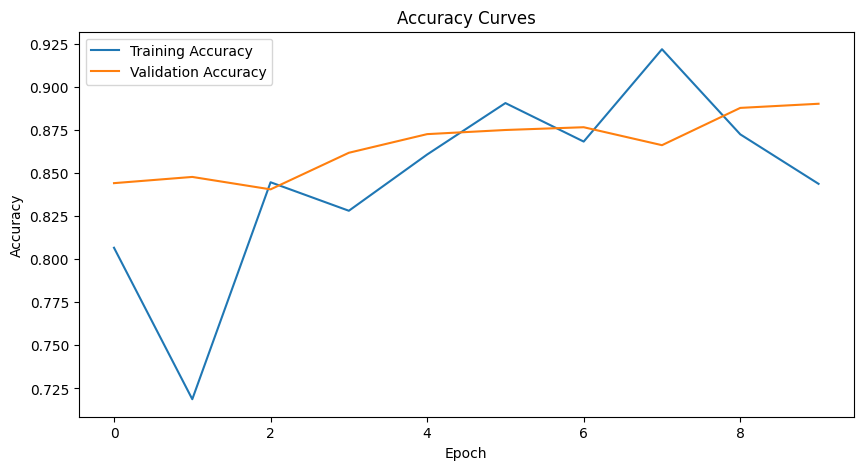

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

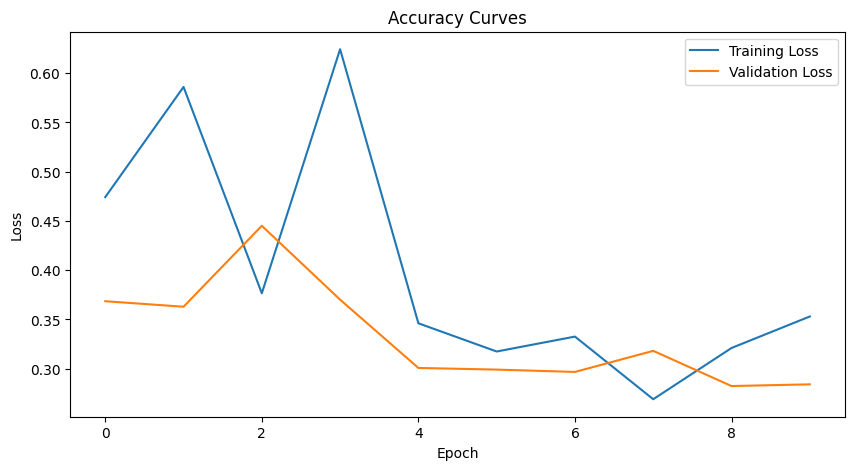

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_generator)
predictions = model.predict(test_generator)

40/40 ━━━━━━━━━━━━━━━━━━━━ 968s 25s/step - accuracy: 0.8781 - loss: 0.3114
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 291ms/step


In [ ]:
y_true = test_generator.classes

y_pred = np.argmax(predictions, axis=1)
print(f"Akurasi: {accuracy_score(y_true, y_pred)}")
print(f"Presisi: {precision_score(y_true, y_pred, average='macro')}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro')}")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

Akurasi: 0.8876494023904382
Presisi: 0.8867048306634029
Recall: 0.8853436564053478
              precision    recall  f1-score   support

   Anorganik       0.88      0.87      0.87      1112
     Organik       0.89      0.91      0.90      1398

    accuracy                           0.89      2510
   macro avg       0.89      0.89      0.89      2510
weighted avg       0.89      0.89      0.89      2510



In [ ]:
# Simpan dalam format SavedModel
export_dir = '/content/saved_model'
tf.saved_model.save(model, export_dir)

# 6 Prediksi Gambar

In [ ]:
def predict_image_from_path(image_path, model, class_indices):
    """
    Memuat gambar dari path, melakukan preprocessing, dan memprediksi kelasnya.

    Args:
        image_path (str): Path ke file gambar.
        model (tf.keras.Model): Model TensorFlow yang telah dilatih.
        class_indices (dict): Dictionary yang memetakan nama kelas ke indeks numerik.

    Returns:
        str: Nama kelas yang diprediksi, atau None jika terjadi error.
    """
    try:

        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Gagal memuat gambar dari {image_path}")
            return None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

        img = preprocess_input(img)


        img = np.expand_dims(img, axis=0)

        predictions = model.predict(img)

        predicted_class_index = np.argmax(predictions, axis=1)[0]

        idx_to_class = {v: k for k, v in class_indices.items()}
        predicted_class_name = idx_to_class[predicted_class_index]

        return predicted_class_name

    except Exception as e:
        print(f"Error saat memproses gambar {image_path}: {e}")
        return None


image_to_predict_path = '/content/download (2).jpeg'

class_indices = train_generator.class_indices

predicted_class = predict_image_from_path(image_to_predict_path, model, class_indices)

if predicted_class:
    print(f"Gambar '{image_to_predict_path}' diprediksi sebagai: {predicted_class}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Gambar '/content/download (2).jpeg' diprediksi sebagai: Anorganik


In [ ]:
# Mengonversi model ke format TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TF-Lite ke file
tflite_dir = '/content/tflite'
os.makedirs(tflite_dir, exist_ok=True)

# Menyimpan file .tflite
with open(os.path.join(tflite_dir, 'model.tflite'), 'wb') as f:
    f.write(tflite_model)

print(f"Model telah disimpan dalam format TF-Lite di folder {tflite_dir}.")

Saved artifact at '/tmp/tmphi1xsq9s'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_33')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  138112048835152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138112048836496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138112048835920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138112048837264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138112048836688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138112048838032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138112048837456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138112048838800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138112048838224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138112048839568: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model telah d